## Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Step 1: Transform and split the data

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 1.95
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [6]:
# look up zero-inflated fits for beta, we're throwing out a small fraction of 0-like videos
prior_a, prior_b, loc, scale = beta.fit([i for i in train_videos.values if i != 0], floc=0, fscale=1)

In [7]:
r = beta.rvs(prior_a, prior_b, size=5000)

Text(0.5, 1.0, 'density plot of eb beta prior')

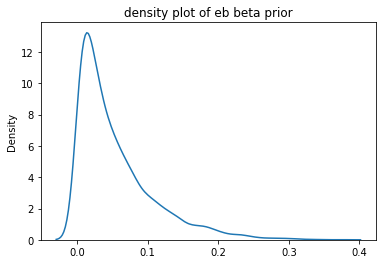

In [8]:
sns.kdeplot(r).set_title('density plot of eb beta prior')

In [9]:
video_df

video_id
103      0.025532
109      0.053154
120      0.102055
122      0.031228
128      0.023388
           ...   
10506    0.080351
10519    0.177098
10552    0.006383
10589    0.059914
10595    0.107988
Name: liked, Length: 3327, dtype: float64

## Step 2: Merge the datasets and select from test set different products

In [10]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [11]:
kuairec_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,like_ratio
0,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,0,0.145996
1,19,183,8033,6100,2020-07-25 09:51:33.664,20200725.0,1.595642e+09,1.316885,0,0.145996
2,21,183,15770,6100,2020-07-08 07:00:20.865,20200708.0,1.594163e+09,2.585246,1,0.145996
3,23,183,20786,6100,2020-07-05 07:50:01.81,20200705.0,1.593907e+09,3.407541,1,0.145996
4,24,183,4737,6100,2020-07-05 03:47:59.561,20200705.0,1.593892e+09,0.776557,0,0.145996


Text(0.5, 1.0, 'histogram of like ratios')

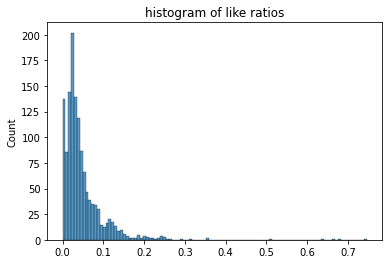

In [12]:
sns.histplot(test_videos.values).set_title('histogram of like ratios')

In [41]:
num_samples = 600

In [42]:
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))

In [44]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [46]:
video_df[sampled_videos].sort_values()

video_id
2007    0.000000
1197    0.000000
5998    0.000000
9136    0.000000
883     0.000000
          ...   
6879    0.248227
7559    0.253012
3723    0.311127
5464    0.662411
1305    0.676596
Name: liked, Length: 600, dtype: float64

In [50]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[-1, -2, num_samples//5, 2*num_samples//5, 3*num_samples//5, 4*num_samples//5]].keys())
videos_of_interest

[1305, 5464, 4226, 1997, 586, 6283]

In [61]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

## Step 3: Set up the bandit environment

In [51]:
# set up experiment in a way where we can later interpolate between uninformed prior and eb
uninformed_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2)
eb_priors = np.array([[prior_a]*len(sampled_videos),[prior_b]*len(sampled_videos)]).T

In [52]:
def random_argmax(alist):
  maxval = max(alist)
  argmax = [idx for idx, val in enumerate(alist) if val == maxval]
  return np.random.choice(argmax)

def ts_action(actions, num_success, num_failure):
  p_hat = [np.random.beta(num_success[a],num_failure[a]) for a in actions]
  a = random_argmax(p_hat)
  return a

def greedy_action(actions, num_success, num_failure):
  p_hat = [(num_success[a] + 1) / (num_success[a] + num_failure[a] + 2) for a in actions]
  a = random_argmax(p_hat)
  return a

def epsilon_greedy_action(actions, num_success, num_failure):
  if np.random.binomial(1, 0.05):
    a = np.random.choice(actions)
  else:
    a = greedy_action(actions, num_success, num_failure)
  return a

def sample_chosen_df(videos, chosen_df, action_index):
    vid = videos[action_index]
    seen_like = chosen_df[chosen_df['video_id']==vid].sample(1).iloc[0]['liked']
    return seen_like

In [53]:
def run_multiarmed_bandit(chosen_df, 
                          videos, 
                          priors, 
                          sampling_action, 
                          timesteps, 
                          num_sims):

    agg_priors_over_time = []
    rewards_over_time = []
    plays = []
    
    for n in range(num_sims):
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        instance_plays = np.zeros(len(videos))
        
        for t in range(timesteps):
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0,:], newest_prior.T[1,:]
            actions = range(len(videos))
            
            a = sampling_action(actions, successes, failures)
            
            instance_plays[a] += 1
            
            like = sample_chosen_df(videos, chosen_df, a)
            
            # update prior
            newest_prior[a,0] += like
            newest_prior[a,1] += 1 - like
            instance_priors_over_time.append(newest_prior)
            
            newest_rewards[a] += like
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        agg_priors_over_time.append(instance_priors_over_time)
        rewards_over_time.append(instance_rewards_over_time)
        plays.append(instance_plays)
        
    agg_priors_over_time = np.stack(agg_priors_over_time)
    rewards_over_time = np.stack(rewards_over_time)
    plays = np.stack(plays)
            
    return agg_priors_over_time, rewards_over_time, plays
            
        

## Step 4: Run the simulations and save data

In [54]:
timesteps = 100
num_sims = 100

In [55]:
uninformed_prior_data, uninformed_rewards_data, uninformed_plays_data = run_multiarmed_bandit(kuairec_chosen,
                                                                       sampled_videos,
                                                                       uninformed_priors,
                                                                       ts_action,
                                                                       timesteps=timesteps,
                                                                       num_sims=num_sims)

In [56]:
eb_prior_data, eb_rewards_data, eb_plays_data = run_multiarmed_bandit(kuairec_chosen,
                                                       sampled_videos,
                                                       eb_priors,
                                                       ts_action,
                                                       timesteps=timesteps,
                                                       num_sims=num_sims)

In [57]:
uninformed_greedy_prior_data, uninformed_greedy_rewards_data, uninformed_greedy_plays_data = run_multiarmed_bandit(kuairec_chosen,
                                                                       sampled_videos,
                                                                       uninformed_priors,
                                                                       epsilon_greedy_action,
                                                                       timesteps=timesteps,
                                                                       num_sims=num_sims)

In [58]:
eb_greedy_prior_data, eb_greedy_rewards_data, eb_greedy_plays_data = run_multiarmed_bandit(kuairec_chosen,
                                                                       sampled_videos,
                                                                       eb_priors,
                                                                       epsilon_greedy_action,
                                                                       timesteps=timesteps,
                                                                       num_sims=num_sims)

## Step 5: Plot and analyze the data

In [64]:
print(uninformed_prior_data.shape)
print(uninformed_rewards_data.shape)
print(uninformed_plays_data.shape)

(100, 101, 600, 2)
(100, 101, 600)
(100, 600)


In [66]:
uninformed_prior_data_agg = uninformed_prior_data[:,:,indices_of_interest,:].sum(axis=0)/num_sims
eb_prior_data_agg = eb_prior_data[:,:,indices_of_interest,:].sum(axis=0)/num_sims
uninformed_greedy_prior_data_agg = uninformed_greedy_prior_data[:,:,indices_of_interest,:].sum(axis=0)/num_sims
eb_greedy_prior_data_agg = eb_greedy_prior_data[:,:,indices_of_interest,:].sum(axis=0)/num_sims

uninformed_rewards = uninformed_rewards_data[:,:,indices_of_interest].mean(axis=0)
eb_rewards = eb_rewards_data[:,:,indices_of_interest].mean(axis=0)
uninformed_greedy_rewards = uninformed_greedy_rewards_data[:,:,indices_of_interest].mean(axis=0)
eb_greedy_rewards = eb_greedy_rewards_data[:,:,indices_of_interest].mean(axis=0)

uninformed_plays = uninformed_plays_data[:,indices_of_interest].mean(axis=0)
eb_plays = eb_plays_data[:,indices_of_interest].mean(axis=0)
uninformed_greedy_plays = uninformed_greedy_plays_data[:,indices_of_interest].mean(axis=0)
eb_greedy_plays = eb_greedy_plays_data[:,indices_of_interest].mean(axis=0)

In [67]:
# calculate means

uninformed_means = uninformed_prior_data_agg[:,:,0]/(uninformed_prior_data_agg[:,:,0]+uninformed_prior_data_agg[:,:,1])
eb_means = eb_prior_data_agg[:,:,0]/(eb_prior_data_agg[:,:,0] + eb_prior_data_agg[:,:,1])
uninformed_greedy_means = uninformed_greedy_prior_data_agg[:,:,0]/(uninformed_greedy_prior_data_agg[:,:,0] + uninformed_greedy_prior_data_agg[:,:,1])
eb_greedy_means = eb_greedy_prior_data_agg[:,:,0]/(eb_greedy_prior_data_agg[:,:,0] + eb_greedy_prior_data_agg[:,:,1])

In [87]:
# calculate confidence intervals
uninf_conf_width = beta.interval(0.95, uninformed_prior_data[:,:,indices_of_interest,0], uninformed_prior_data[:,:,indices_of_interest,1])
uninf_conf_width = uninf_conf_width[1] - uninf_conf_width[0]
uninf_conf_width = uninf_conf_width.mean(axis=0)
eb_conf_width = beta.interval(0.95, eb_prior_data[:,:,indices_of_interest,0], eb_prior_data[:,:,indices_of_interest,1])
eb_conf_width = eb_conf_width[1] - eb_conf_width[0]
eb_conf_width = eb_conf_width.mean(axis=0)
uninf_greedy_conf_width = beta.interval(0.95, uninformed_greedy_prior_data[:,:,indices_of_interest,0], uninformed_greedy_prior_data[:,:,indices_of_interest,1])
uninf_greedy_conf_width = uninf_greedy_conf_width[1] - uninf_greedy_conf_width[0]
uninf_greedy_conf_width = uninf_greedy_conf_width.mean(axis=0)
eb_greedy_conf_width = beta.interval(0.95, eb_greedy_prior_data[:,:,indices_of_interest,0], eb_greedy_prior_data[:,:,indices_of_interest,1])
eb_greedy_conf_width = eb_greedy_conf_width[1] - eb_greedy_conf_width[0]
eb_greedy_conf_width = eb_greedy_conf_width.mean(axis=0)

In [78]:
video_df[videos_of_interest]

video_id
1305    0.676596
5464    0.662411
4226    0.014174
1997    0.024805
586     0.038271
6283    0.068230
Name: liked, dtype: float64

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.5138 0.5183 0.4464 0.4566 0.4608 0.463 ]
arm pulls [0.18 0.18 0.24 0.19 0.17 0.16]


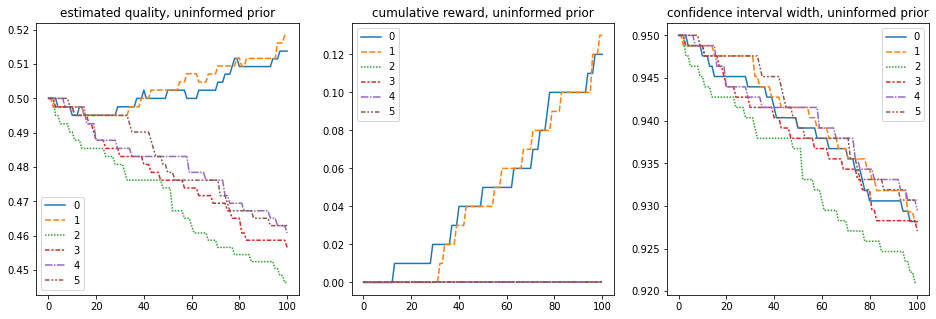

In [79]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(16, 5)
sns.lineplot(uninformed_means, ax=axes[0]).set_title('estimated quality, uninformed prior')
sns.lineplot(uninformed_rewards, ax=axes[1]).set_title('cumulative reward, uninformed prior')
sns.lineplot(uninf_conf_width, ax=axes[2]).set_title('confidence interval width, uninformed prior')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', uninformed_means[-1,:].round(4))
print('arm pulls', uninformed_plays)

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.0668 0.0636 0.0538 0.0542 0.0544 0.0538]
arm pulls [0.32 0.27 0.15 0.22 0.15 0.17]


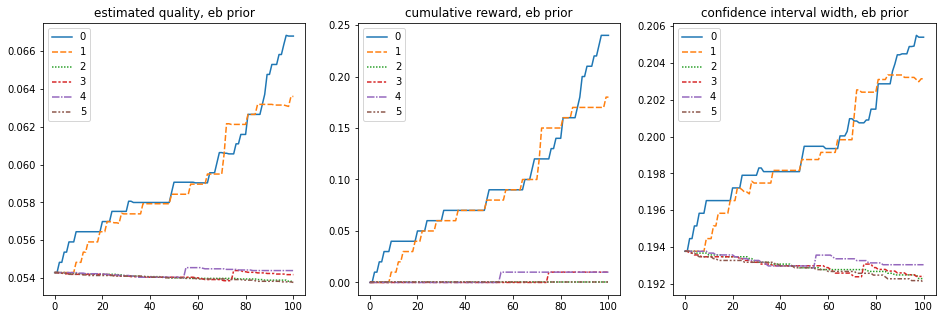

In [83]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(16, 5)
sns.lineplot(eb_means, ax=axes[0]).set_title('estimated quality, eb prior')
sns.lineplot(eb_rewards, ax=axes[1]).set_title('cumulative reward, eb prior')
sns.lineplot(eb_conf_width, ax=axes[2]).set_title('confidence interval width, eb prior')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', eb_means[-1,:].round(4))
print('arm pulls', eb_plays)

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.6005 0.5749 0.463  0.472  0.4525 0.4742]
arm pulls [2.28 2.07 0.16 0.14 0.21 0.13]


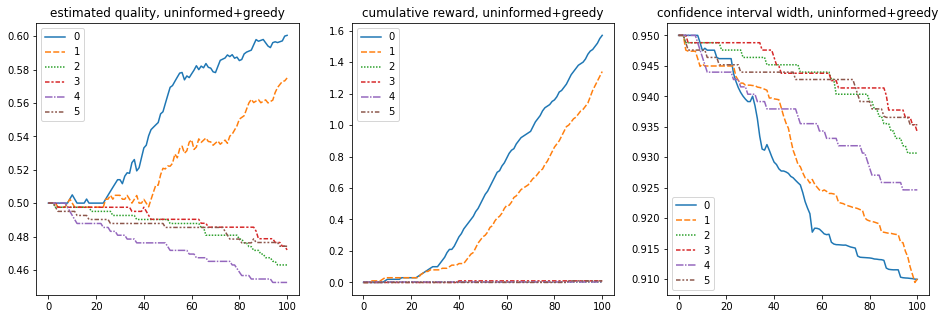

In [84]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(16, 5)
sns.lineplot(uninformed_greedy_means, ax=axes[0]).set_title('estimated quality, uninformed+greedy')
sns.lineplot(uninformed_greedy_rewards, ax=axes[1]).set_title('cumulative reward, uninformed+greedy')
sns.lineplot(uninf_greedy_conf_width, ax=axes[2]).set_title('confidence interval width, uninformed+greedy')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', uninformed_greedy_means[-1,:].round(4))
print('arm pulls', uninformed_greedy_plays)

true vals [0.6766, 0.6624, 0.0142, 0.0248, 0.0383, 0.0682]
estimated means [0.0668 0.1114 0.054  0.0541 0.054  0.0541]
arm pulls [0.47 1.81 0.1  0.05 0.08 0.07]


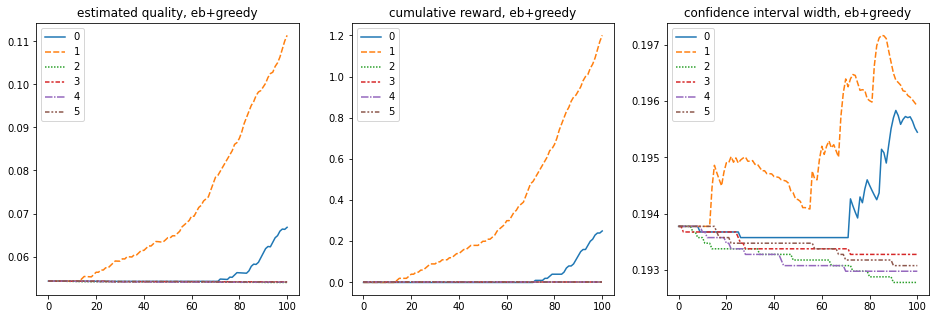

In [85]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(16, 5)
sns.lineplot(eb_greedy_means, ax=axes[0]).set_title('estimated quality, eb+greedy')
sns.lineplot(eb_greedy_rewards, ax=axes[1]).set_title('cumulative reward, eb+greedy')
sns.lineplot(eb_greedy_conf_width, ax=axes[2]).set_title('confidence interval width, eb+greedy')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', eb_greedy_means[-1,:].round(4))
print('arm pulls', eb_greedy_plays)